In [26]:
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
from train import Config, SiameseNetwork, normalize

In [27]:
class TestSiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset  
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = self.imageFolderDataset.imgs[index]#imgs has the form like [('./person_i/xxx.jpg',label_i),...]
        img0 = Image.open(img0_tuple[0])
        
        #global HSV feature
        img0_hsv = img0.convert('HSV')
        
        #local Laplacian texture feature
        img0_grad = cv2.imread(img0_tuple[0])
        img0_grad = cv2.Laplacian(img0_grad,cv2.CV_16S,ksize = 3)
        img0_grad = cv2.convertScaleAbs(img0_grad)#absolute value
        img0_grad = Image.fromarray(img0_grad.astype('uint8')).convert('RGB')
        
        if self.transform is not None:
            img0_hsv = self.transform(img0_hsv)
            img0_grad = self.transform(img0_grad)
        label = img0_tuple[1]
        return img0_hsv, img0_grad, label
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [28]:
def f_Distance(img0_hsv, img0_grad, img1_hsv, img1_grad):
    a = 0.9
    output0_hsv,output1_hsv = net(Variable(img0_hsv),Variable(img1_hsv))
    output0_grad,output1_grad = net(Variable(img0_grad),Variable(img1_grad))
    output0 = torch.cat((a * output0_hsv, (1-a) * output0_grad), 1)
    output1 = torch.cat((a * output1_hsv, (1-a) * output1_grad), 1)
                
    euclidean_distance = F.pairwise_distance(output0, output1)
    cos_distance = np.linalg.norm(normalize(output0.data.numpy()[0]) - normalize(output1.data.numpy()[0]))
    distance  = cos_distance * euclidean_distance
    return distance

0
1
pass
2
pass
3
pass
4
5
pass
6
pass
7
pass
8
9
pass
10
pass
11
pass
12
13
pass
14
pass
15
pass
16
17
pass
18
pass
19
pass
20
21
pass
22
pass
23
pass
24
25
pass
26
pass
27
pass
28
29
pass
30
pass
31
pass
32
33
pass
34
pass
35
pass
36
37
pass
38
pass
39
pass
40
41
pass
42
pass
43
pass
44
45
pass
46
pass
47
pass
48
49
pass
50
pass
51
pass
52
53
pass
54
pass
55
pass
56
57
pass
58
pass
59
pass
60
61
pass
62
pass
63
pass
64
65
pass
66
pass
67
pass
68
69
pass
70
pass
71
pass
72
73
pass
74
pass
75
pass
76
77
pass
78
pass
79
pass
80
81
pass
82
pass
83
pass
84
85
pass
86
pass
87
pass
88
89
pass
90
pass
91
pass
92
93
pass
94
pass
95
pass
96
97
pass
98
pass
99
pass
100
101
pass
102
pass
103
pass
104
105
pass
106
pass
107
pass
108
109
pass
110
pass
111
pass
112
113
pass
114
pass
115
pass
116
117
pass
118
pass
119
pass
120
121
pass
122
pass
123
pass
124
125
pass
126
pass
127
pass
128
129
pass
130
pass
131
pass
132
133
pass
134
pass
135
pass
136
137
pass
138
pass
139
pass
140
141
pass
142
pass
143

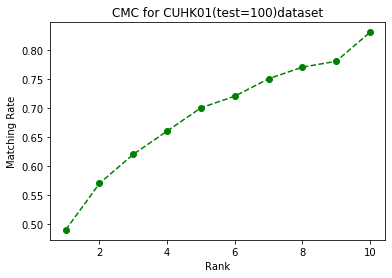

rank1:0.49
rank5:0.7
rank10:0.83
rank20:0.89


In [29]:
if __name__=='__main__':
    net = SiameseNetwork()
    
    #load model
    save_p = "./net_test.pth"
    checkpoint = torch.load(save_p)
    net.load_state_dict(checkpoint['net'])
    
    #load test_set
    folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
    test_siamese_dataset = TestSiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                                     transform=transforms.Compose([transforms.Resize((160,60)),
                                                                                   transforms.ToTensor()]))
    test_dataloader = DataLoader(test_siamese_dataset,num_workers=0,batch_size=1,shuffle=True)

    #for 100 people in test dataset, take their 1st photo to compare other 399 pictures, and sort them by similarities.
    match_rank = []#100*399 size matrix
    a = 0.9
    for i,data_i in enumerate(test_dataloader,0):
    
        #take everyones's first photo of 4.
        print(i)#view test process where i∈[0,400) 
        if i%4 !=0:
            print('pass')#not use
            continue
        else:
            img0_hsv, img0_grad, label_0 = data_i
            query = []
        
            #take every different photo to compare similarity
            for j,data_j in enumerate(test_dataloader,0):
                img1_hsv, img1_grad, label_1 = data_j
                if torch.equal(img0_hsv, img1_hsv):
                    continue
                else:
                    distance  = f_Distance(img0_hsv, img0_grad, img1_hsv, img1_grad)
                    distance = distance.detach().numpy()
                    label_1 = label_1.numpy()
                    query.append([distance,label_1])
            query = sorted(query,key=(lambda x:x[0]))
        
            #calculate Rank function: y=f(x), y=1 if x>=xi when f(xi)=1, otherwise y=0 
            flag = 0
            match_rank_i = []
            for k in range(len(query)):
                if flag == 1:
                    match_rank_i.append(1)
                else:
                    if query[k][1] == label_0.numpy():
                        flag = 1
                        match_rank_i.append(1)
                    else:
                        match_rank_i.append(0)            
            match_rank.append(match_rank_i)

    #plot CMC graph
    match_rate=np.sum(match_rank,axis=0)/len(match_rank)
    match_rate_10 = match_rate[0:10]
    x = [i+1 for i in range(10)]
    plt.plot(x, match_rate_10, color='green', marker='o', linestyle='dashed', label='Ours')
    plt.xlabel('Rank')
    plt.ylabel('Matching Rate')
    plt.title('CMC for CUHK01(test=100)dataset')
    plt.show()
    print('rank1:{}'.format(match_rate[0]))
    print('rank5:{}'.format(match_rate[4]))
    print('rank10:{}'.format(match_rate[9]))
    print('rank20:{}'.format(match_rate[19]))